In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import shutil
import sys
from configobj import ConfigObj
import json
from distutils.util import strtobool
import h5py
# from calfews_src.model_cy cimport Model
from calfews_src.inputter_cy import Inputter
from calfews_src.scenario import Scenario
from calfews_src.util import *
from calfews_src.plotter import *
from calfews_src.visualizer import Visualizer
from datetime import datetime

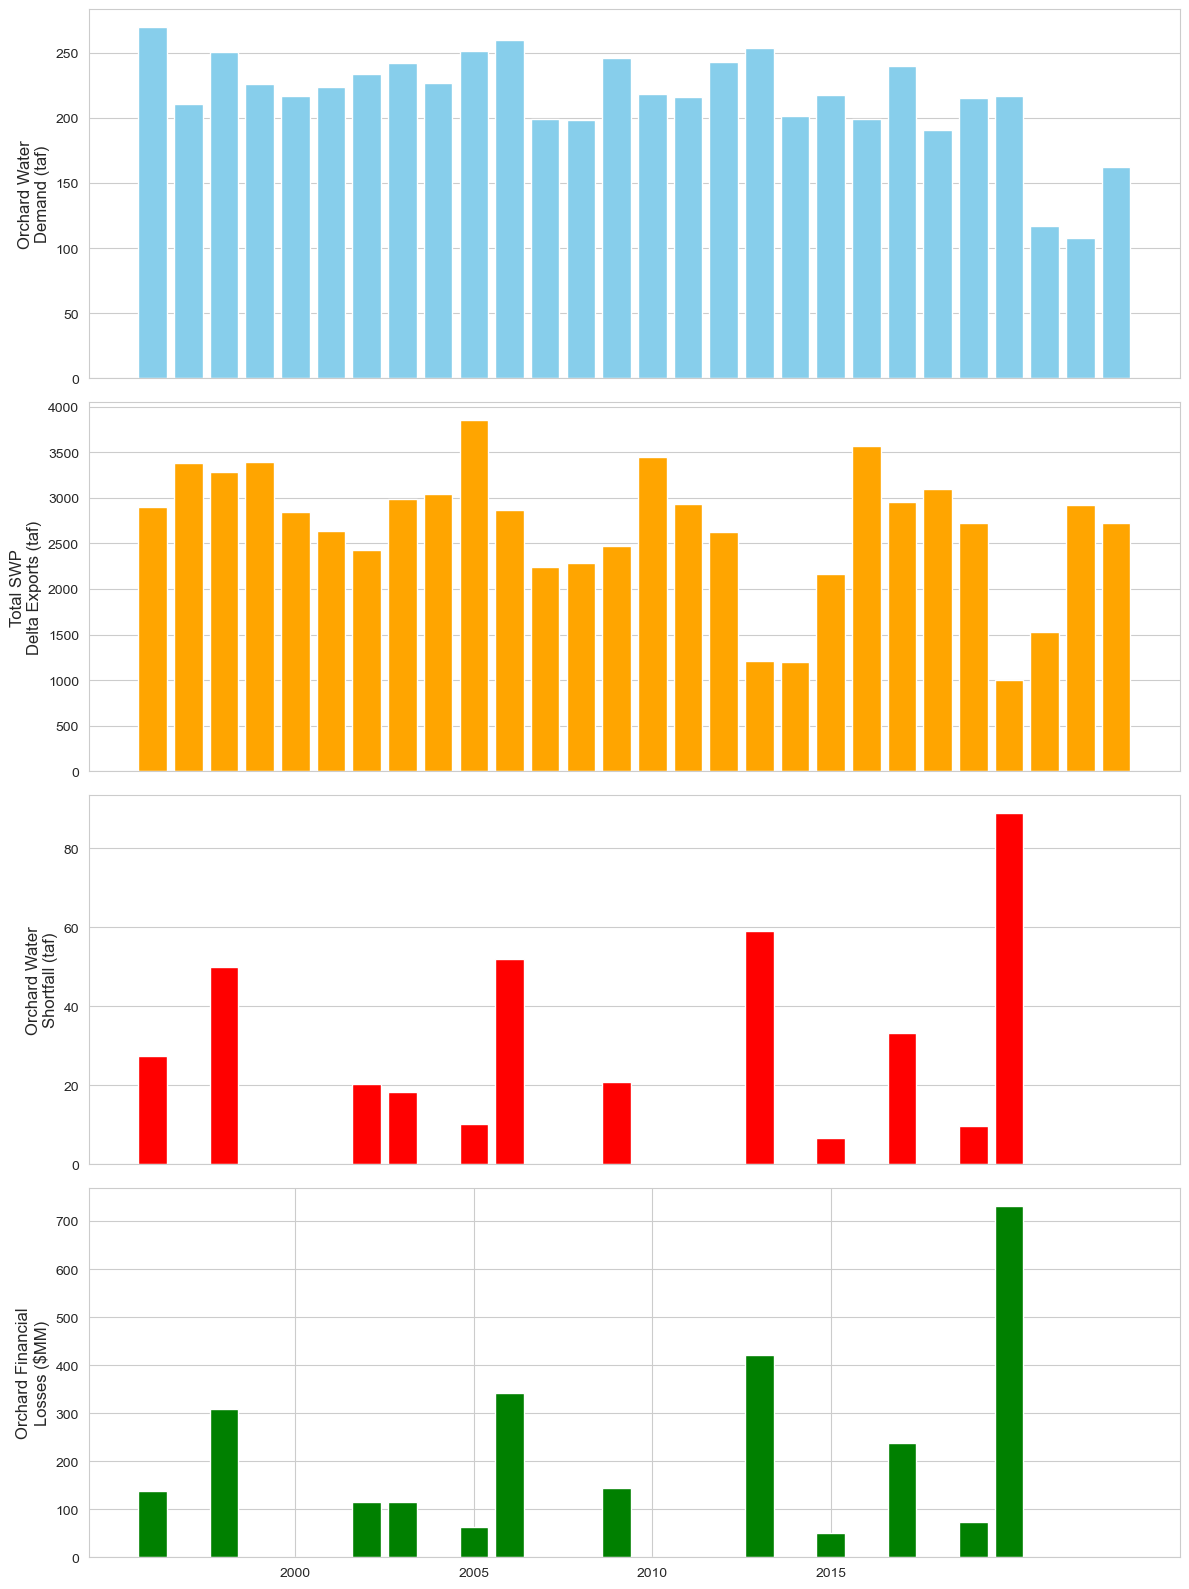

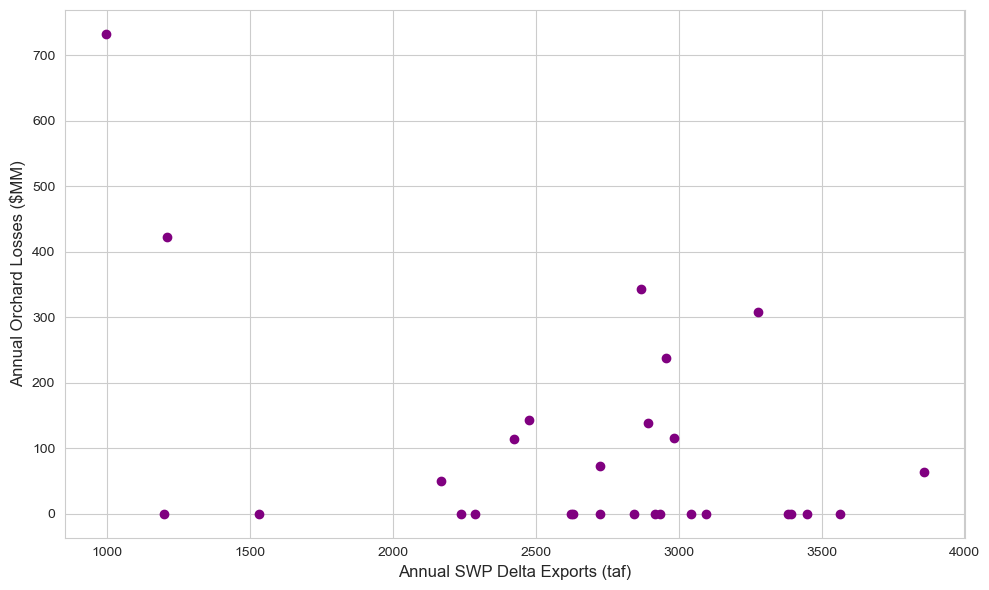

In [23]:
output_folder = "results/short_test/"
output_file = output_folder + 'results.hdf5'
datDaily = get_results_sensitivity_number_outside_model(output_file, '')
validation = datDaily
list_of_water_users = ['wonderful_BLR', 'wonderful_LHL', 'wonderful_BDM']

# Initialize total acreage for each crop
total_acres_almond = (21.385 + 7.175 + 8.042) * 1000.0
total_acres_pistachio = (12.060 + 13.685 + 13.72) * 1000.0

# Initialize cost and revenue from agricultural production
# Immature pistachios (by year of immaturity)
cost_per_acre_pistachio = [3469, 822, 968, 1071, 1394, 1794]
revenue_per_acre_pistachio = [0, 0, 0, 0, 0, 1272]
immature_acres_pistachio = np.zeros(6)

# Mature pistachios
mature_operating_costs_pistachio = 3210
mature_revenues_pistachio = 5997

# Immature almonds
cost_per_acre_almond = [6565, 1462, 2358, 3171, 3691]
revenue_per_acre_almond = [0, 0, 600, 1200, 2400]
immature_acres_almond = np.ones(5) * total_acres_almond / 25.0

# Mature almonds
mature_operating_costs_almond = 3987
mature_revenues_almond = 7500

# Almonds stop being productive after 25 years
acres_by_year_almond = np.ones(25) * total_acres_almond / 25.0

annual_delta_exports = validation['delta_HRO_pump'].resample('AS-OCT').sum()

annual_deliveries = 0
annual_pumping = 0
annual_exchanged = 0

for wu in list_of_water_users:
    delivery_col = f'{wu}_tableA_delivery'
    pumping_col = f'{wu}_pumping'
    exchanged_col = f'{wu}_exchanged_GW'
    
    if not all(col in validation.columns for col in [delivery_col, pumping_col, exchanged_col]):
        raise ValueError(f"One or more required columns for water user '{wu}' are missing.")

    deliveries = validation[delivery_col].resample('AS-OCT').max()
    pumping = validation[pumping_col].resample('AS-OCT').sum()
    exchanged = validation[exchanged_col].resample('AS-OCT').max()
    
    annual_deliveries += deliveries
    annual_pumping += pumping
    annual_exchanged += exchanged

# the percent of land fallowed is equal to the percent of irrigation
# calfews determines is met through 'pumping'
# we assume there is no GW pumping available in these lands, so 
# this land must be fallowed. this can be adjusted to reflect pumping 'limits'
total_water_demand = annual_deliveries + annual_pumping
adjusted_water_demand = np.zeros(len(total_water_demand))
adjusted_shortfall = np.zeros(len(total_water_demand))
annual_cost = np.zeros(len(total_water_demand))

# Loop through each year of the simulation
for year_sim in range(len(total_water_demand)):
    # we assume that any fallowed orchards are immediately replanted
  # but immature acres use 25% of the water that mature acres use
  # so any 'fallowed' acres must first account for the lower water demands
  # of immature acres (this is not included in CALFEWS model so must be post-processed)
    immature_fraction = (immature_acres_almond.sum() + immature_acres_pistachio.sum()) / (total_acres_almond + total_acres_pistachio)
    adjusted_water_demand[year_sim] = total_water_demand.iloc[year_sim] * (1.0 - 0.75 * immature_fraction)
   
    adjusted_shortfall[year_sim] = max(adjusted_water_demand[year_sim] - annual_deliveries.iloc[year_sim], 0.0)
    pct_fallowed = adjusted_shortfall[year_sim] / adjusted_water_demand[year_sim] if adjusted_water_demand[year_sim] > 0 else 0.0
    fallowed_almonds = pct_fallowed * total_acres_almond
    fallowed_pistachios = pct_fallowed * total_acres_pistachio
    
  # cost of fallowing is equal to (revenue - cost) for mature orchards
  # minus (revenue - cost) for immature orchards
  # since orchards take 6 years to mature, costs accrue across 6 years
  # revenue - cost for immature orchards changes based on the age
    for year_loss in range(len(cost_per_acre_pistachio)):
        discounted_factor = 1.05 ** year_loss
        revenue_loss = (mature_revenues_pistachio + cost_per_acre_pistachio[year_loss] -
                        mature_operating_costs_pistachio - revenue_per_acre_pistachio[year_loss])
        annual_cost[year_sim] += (fallowed_pistachios * revenue_loss) / discounted_factor
    
  # cost of fallowing is the same for almonds, except
  # we need to account for the fact that all 25 year old
  # almond trees are fallowed regardless of irrigation availability
    total_fallowed_almonds = 0.0
    for age_year in reversed(range(25)): # fallow oldest almond trees first, loop through ages backwards
        # if fallowed_almonds <= 0:
        #     break
        age_fallowed = min(acres_by_year_almond[age_year], fallowed_almonds)
        # if age_fallowed <= 0:
        #     continue
        
        for year_loss in range(len(cost_per_acre_almond)):
            expected_age = age_year + year_loss
            discounted_factor = 1.05 ** year_loss
            if expected_age < 25:
                revenue_loss = (mature_revenues_almond + cost_per_acre_almond[year_loss] -
                                mature_operating_costs_almond - revenue_per_acre_almond[year_loss])
            else:
                # if the tree would have been fallowed, compare revenues/costs to younger immature tree 
                adjusted_year = expected_age - 25
                if adjusted_year < len(revenue_per_acre_almond):
                    revenue_loss = (revenue_per_acre_almond[adjusted_year] +
                                    cost_per_acre_almond[year_loss] -
                                    cost_per_acre_almond[adjusted_year] -
                                    revenue_per_acre_pistachio[year_loss])
                else:
                    revenue_loss = 0  # Handle cases where adjusted_year exceeds list length
            annual_cost[year_sim] += (age_fallowed * revenue_loss) / discounted_factor
        # record the fallowing in the correct age group
        acres_by_year_almond[age_year] -= age_fallowed
        fallowed_almonds -= age_fallowed
        total_fallowed_almonds += age_fallowed
    
    # Update pistachio acres
    total_acres_pistachio -= fallowed_pistachios
    total_acres_pistachio += immature_acres_pistachio[-1]
    
    # Age immature pistachios
    immature_acres_pistachio[1:] = immature_acres_pistachio[:-1]
    immature_acres_pistachio[0] = fallowed_pistachios

    total_fallowed_almonds += acres_by_year_almond[-1]  # Fallow 25-year-old trees
    acres_by_year_almond[1:] = acres_by_year_almond[:-1]
    acres_by_year_almond[0] = immature_acres_almond[-1]
    
    # Age immature almonds
    immature_acres_almond[1:] = immature_acres_almond[:-1]
    immature_acres_almond[0] = total_fallowed_almonds

start_year = annual_water_demand_year_start = annual_water_demand_year_end = None

if isinstance(annual_delta_exports.index, pd.DatetimeIndex):
    start_year = annual_delta_exports.index.year.min()
    end_year = annual_delta_exports.index.year.max()
else:
    start_year = 1997
    end_year = 2016 

years = np.arange(start_year, end_year + 1)

fig, ax = plt.subplots(4, figsize=(12, 16))

ax[0].bar(years, adjusted_water_demand, color='skyblue')
ax[1].bar(years, annual_delta_exports, color='orange')
ax[2].bar(years, adjusted_shortfall, color='red')
ax[3].bar(years, annual_cost / 1e6, color='green')

ax[0].set_ylabel('Orchard Water\nDemand (taf)', fontsize=12)
ax[1].set_ylabel('Total SWP\nDelta Exports (taf)', fontsize=12)
ax[2].set_ylabel('Orchard Water\nShortfall (taf)', fontsize=12)
ax[3].set_ylabel('Orchard Financial\nLosses ($MM)', fontsize=12)


for i in range(3):
    ax[i].set_xticks([])
    ax[i].set_xticklabels('')


ax[3].set_xticks([2000, 2005, 2010, 2015])
ax[3].set_xticklabels([2000, 2005, 2010, 2015])

plt.tight_layout()
plt.show()
plt.close()


fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(annual_delta_exports, annual_cost / 1e6, marker='o', color='purple')
ax.set_ylabel('Annual Orchard Losses ($MM)', fontsize=12)
ax.set_xlabel('Annual SWP Delta Exports (taf)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()
plt.close()


2024-10-01    85.094515
2025-10-01   -87.025771
2026-10-01    -2.238586
Freq: AS-OCT, dtype: float64
2024-10-01    85.094515
2025-10-01   -54.612702
2026-10-01    -1.786176
Freq: AS-OCT, dtype: float64
2024-10-01    85.094515
2025-10-01   -59.318060
2026-10-01    -4.915127
Freq: AS-OCT, dtype: float64
2024-10-01      85.094515
2025-10-01   -1166.544744
2026-10-01    -948.176938
Freq: AS-OCT, dtype: float64
2024-10-01     85.094515
2025-10-01   -302.891720
2026-10-01    -96.783102
Freq: AS-OCT, dtype: float64
2024-10-01    85.094515
2025-10-01   -58.787110
2026-10-01   -20.928921
Freq: AS-OCT, dtype: float64
2024-10-01    85.094515
2025-10-01   -62.065438
2026-10-01    -2.884763
Freq: AS-OCT, dtype: float64
2024-10-01    85.094515
2025-10-01   -74.034304
2026-10-01    -9.538225
Freq: AS-OCT, dtype: float64
2024-10-01    85.094515
2025-10-01   -77.099442
2026-10-01    -8.767009
Freq: AS-OCT, dtype: float64
2024-10-01    85.094515
2025-10-01   -98.717181
2026-10-01    -3.254352
Freq: AS-O

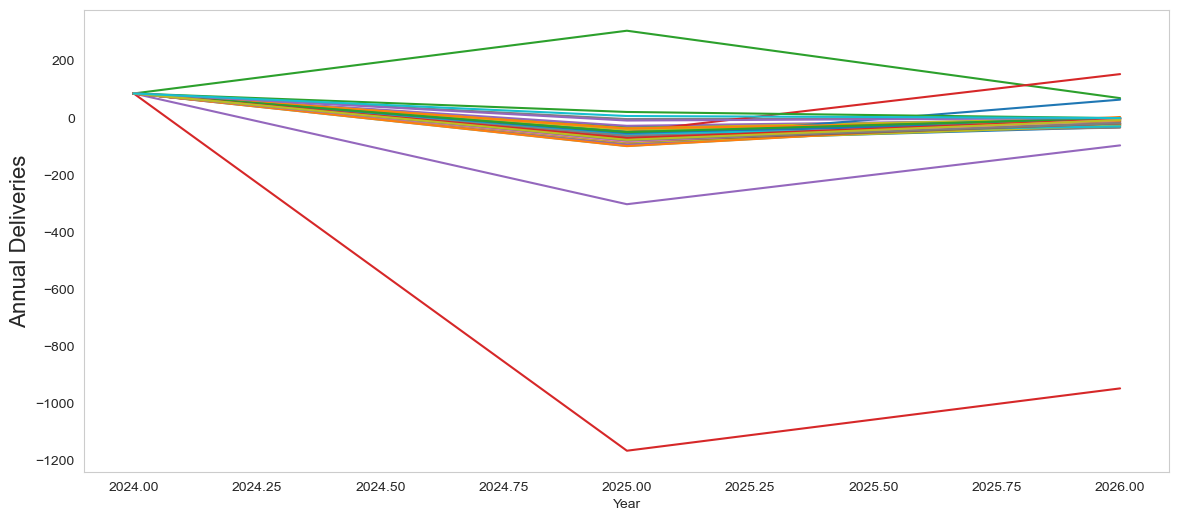

In [73]:
output_folder = "results/"
data_dict = {}

for i in range(1, 101):
    output_file = os.path.join(output_folder, str(i), 'results.hdf5')
    datDaily = get_results_sensitivity_number_outside_model(output_file, '')
    datDaily.index = pd.to_datetime(datDaily.index)  
    
    annual_deliveries = datDaily['wonderful_BLR_tableA_carryover'] + datDaily['wonderful_LHL_tableA_carryover'] + datDaily['wonderful_BDM_tableA_carryover']
    
    yearly_sum = annual_deliveries.resample('AS-OCT').max()
    data_dict[f'Trace {i}'] = yearly_sum.values
    print(yearly_sum)
data_dict['Year'] = yearly_sum.index.year 
df = pd.DataFrame(data_dict)

fig, ax = plt.subplots(figsize=(14, 6))

for key in df.columns:
    if key != 'Year':
        ax.plot(df['Year'], df[key], label=key, alpha=1)

ax.set_xlabel('Year')
ax.set_ylabel('Annual Deliveries', fontsize=16)
# ax.legend()
ax.grid(False)
plt.show()

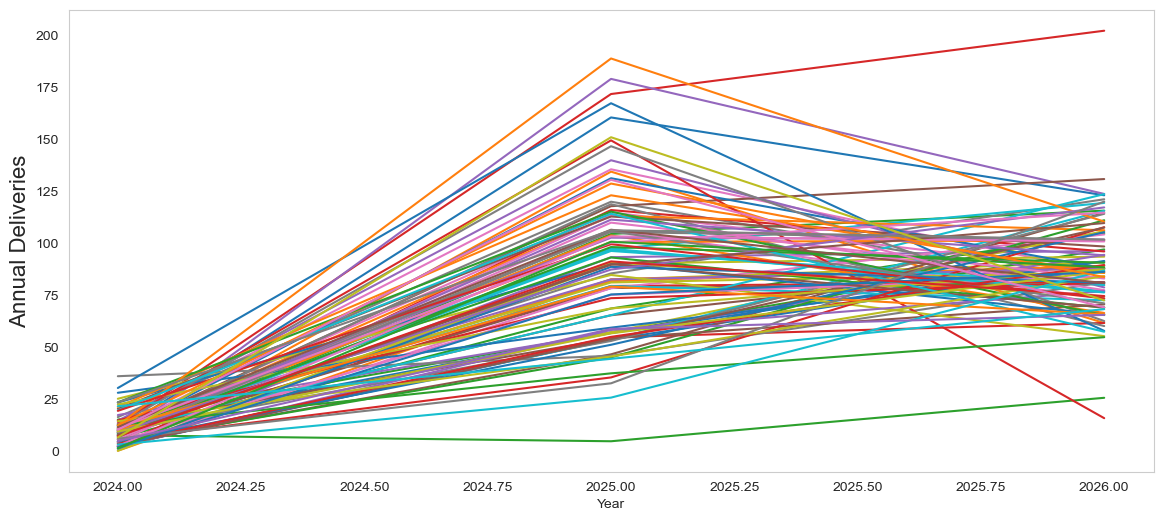

In [49]:
output_folder = "results/"
data_dict = {}

for i in range(1, 101):
    output_file = os.path.join(output_folder, str(i), 'results.hdf5')
    datDaily = get_results_sensitivity_number_outside_model(output_file, '')
    datDaily.index = pd.to_datetime(datDaily.index)  
    
    annual_pumping  = datDaily['wonderful_BLR_pumping'] + datDaily['wonderful_LHL_pumping'] + datDaily['wonderful_BDM_pumping']
    
    yearly_sum = annual_pumping.resample('AS-OCT').sum()
    data_dict[f'Trace {i}'] = yearly_sum.values

data_dict['Year'] = yearly_sum.index.year 
df = pd.DataFrame(data_dict)

fig, ax = plt.subplots(figsize=(14, 6))

for key in df.columns:
    if key != 'Year':
        ax.plot(df['Year'], df[key], label=key, alpha=1)

ax.set_xlabel('Year')
ax.set_ylabel('Annual Deliveries', fontsize=16)
# ax.legend()
ax.grid(False)
plt.show()

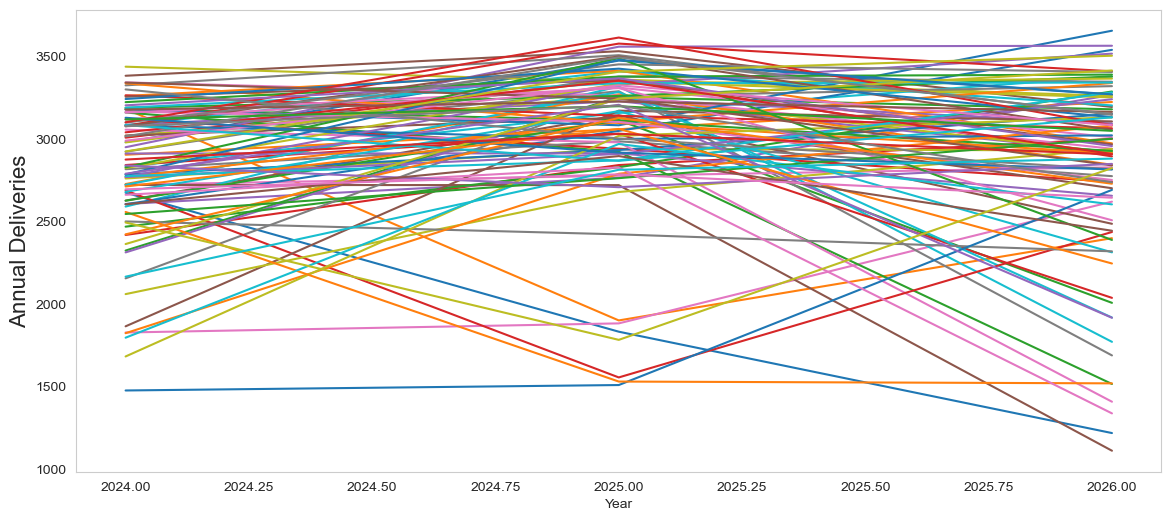

In [70]:
output_folder = "results/"
data_dict = {}

for i in range(1, 101):
    output_file = os.path.join(output_folder, str(i), 'results.hdf5')
    datDaily = get_results_sensitivity_number_outside_model(output_file, '')
    datDaily.index = pd.to_datetime(datDaily.index)  
    
    annual_deliveries = datDaily['delta_HRO_pump']
    # + datDaily['wonderful_LHL_tableA_delivery'] + datDaily['wonderful_BDM_tableA_delivery']
    
    yearly_sum = annual_deliveries.resample('AS-OCT').sum()
    data_dict[f'Trace {i}'] = yearly_sum.values

data_dict['Year'] = yearly_sum.index.year 
df = pd.DataFrame(data_dict)

fig, ax = plt.subplots(figsize=(14, 6))

for key in df.columns:
    if key != 'Year':
        ax.plot(df['Year'], df[key], label=key, alpha=1)

ax.set_xlabel('Year')
ax.set_ylabel('Annual Deliveries', fontsize=16)
# ax.legend()
ax.grid(False)
plt.show()

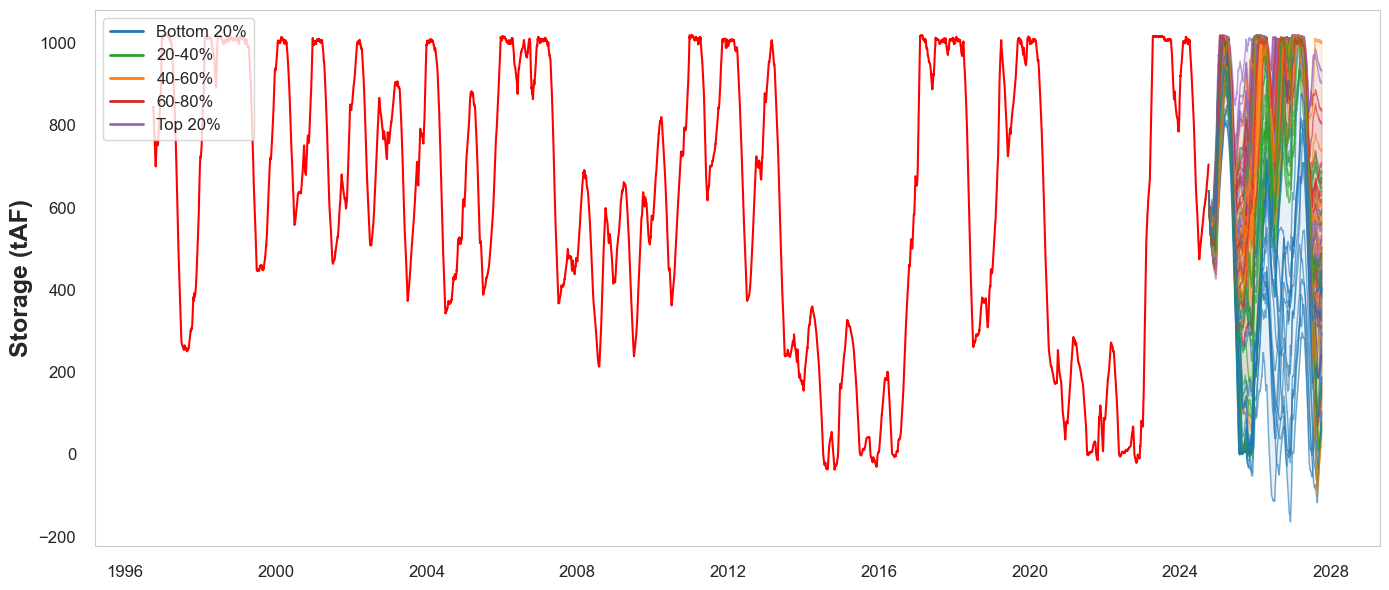

In [71]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
from matplotlib.lines import Line2D


output_folder = "results/"
data_dict = {}

for i in range(1, 101):
    output_file = os.path.join(output_folder, str(i), 'results.hdf5')
    datDaily = get_results_sensitivity_number_outside_model(output_file, '')
    shasta_R_to_delta = datDaily['sanluisstate_S']
    data_dict[f'Trace {i}'] = shasta_R_to_delta


df = pd.DataFrame(data_dict)

fig, ax = plt.subplots(figsize=(14, 6))
trace_medians = df.median()

# Quintiles: 1 (Bottom 20%), 2 (20-40%), 3 (40-60%), 4 (60-80%), 5 (Top 20%)
quintiles = pd.qcut(trace_medians, 5, labels=[1, 2, 3, 4, 5])  # Labels 1 to 5

color_palette = {
    1: '#1f77b4',  # Blue - Bottom 20%
    2: '#2ca02c',  # Green - 20-40%
    3: '#ff7f0e',  # Orange - 40-60%
    4: '#d62728',  # Red - 60-80%
    5: '#9467bd'   # Purple - Top 20%
}

for trace, quintile in zip(data_dict.keys(), quintiles):
    ax.plot(df.index, data_dict[trace], color=color_palette[quintile], alpha=0.6,  linewidth=1)

for q in sorted(color_palette.keys()):
    # Select traces in the current quintile
    quintile_traces = df.columns[quintiles == q]
    quintile_data = df[quintile_traces]
    
    lower = quintile_data.min(axis=1)
    upper = quintile_data.max(axis=1)
  
    ax.fill_between(df.index, lower, upper, color=color_palette[q],  alpha=0.1, label=f'Quintile {q}' if q == 1 else "")  # Label only once to avoid duplicates

legend_elements = [
    Line2D([0], [0], color=color_palette[1], lw=2, label='Bottom 20%'),
    Line2D([0], [0], color=color_palette[2], lw=2, label='20-40%'),
    Line2D([0], [0], color=color_palette[3], lw=2, label='40-60%'),
    Line2D([0], [0], color=color_palette[4], lw=2, label='60-80%'),
    Line2D([0], [0], color=color_palette[5], lw=2, label='Top 20%')
]

handles = legend_elements 
# + shaded_elements
labels = [handle.get_label() for handle in handles]

unique_labels = {}
for handle in handles:
    if handle.get_label() not in unique_labels:
        unique_labels[handle.get_label()] = handle

output_folder = "results/short_test/"
output_file = output_folder + 'results.hdf5'
datDaily_val = get_results_sensitivity_number_outside_model(output_file, '')
ax.plot(datDaily_val['sanluisstate_S'], label = 'output', color = 'red') #

ax.legend(unique_labels.values(), unique_labels.keys(), fontsize=12, loc='upper left')

# ax.set_title('Comparison of Shasta Reservoir Storage (shasta_S) for 100 Traces', 
#              fontsize=18, fontweight='bold')
# ax.set_xlabel('Time', fontsize=14, fontweight='bold')
ax.set_ylabel('Storage (tAF)', fontsize=18, fontweight='bold')

ax.tick_params(axis='x', labelsize=12, pad=10, width=1)
ax.tick_params(axis='y', labelsize=12, pad=10, width=1)

ax.grid(False)

plt.tight_layout()
plt.show()

In [56]:
for x in datDaily.keys():
    print(x)

shasta_S
shasta_R
shasta_R_to_delta
shasta_available_storage
shasta_outflow_release
shasta_days_til_full
shasta_Q
shasta_SNPK
shasta_downstream
shasta_fnf
oroville_S
oroville_R
oroville_R_to_delta
oroville_available_storage
oroville_outflow_release
oroville_days_til_full
oroville_Q
oroville_SNPK
oroville_downstream
oroville_fnf
yuba_S
yuba_R
yuba_R_to_delta
yuba_available_storage
yuba_outflow_release
yuba_days_til_full
yuba_Q
yuba_SNPK
yuba_downstream
yuba_fnf
folsom_S
folsom_R
folsom_R_to_delta
folsom_available_storage
folsom_outflow_release
folsom_days_til_full
folsom_Q
folsom_SNPK
folsom_fnf
newmelones_S
newmelones_R
newmelones_R_to_delta
newmelones_Q
newmelones_SNPK
newmelones_downstream
newmelones_fnf
donpedro_S
donpedro_R
donpedro_R_to_delta
donpedro_Q
donpedro_SNPK
donpedro_downstream
donpedro_fnf
exchequer_S
exchequer_R
exchequer_R_to_delta
exchequer_Q
exchequer_SNPK
exchequer_downstream
exchequer_fnf
sanluisstate_S
sanluisstate_days_til_full
sanluisstate_reclaimed_carryover
sa

In [47]:
datDaily[['wonderful_BLR_pumping','wonderful_LHL_pumping','wonderful_BDM_pumping']].head(50)

,wonderful_BLR_pumping,wonderful_LHL_pumping,wonderful_BDM_pumping
2024-10-01,0.0,0.0,0.0
2024-10-02,0.0,0.0,0.0
2024-10-03,0.0,0.0,0.0
2024-10-04,0.0,0.0,0.0
2024-10-05,0.0,0.0,0.0
2024-10-06,0.0,0.0,0.0
2024-10-07,0.0,0.0,0.0
2024-10-08,0.0,0.0,0.0
2024-10-09,0.0,0.0,0.0
2024-10-10,0.0,0.0,0.0


In [25]:
all_adjusted_water_demand = []
all_annual_delta_exports = []
all_adjusted_shortfall = []
all_annual_cost = []

for i in range(1, 101):
    input_filename = f"results/{i}/source_file.hdf5"
    output_folder = f"results/{i}/"
    output_file = output_folder + 'results.hdf5'

    datDaily = get_results_sensitivity_number_outside_model(output_file, '')
    validation = datDaily
    list_of_water_users = ['wonderful_BLR', 'wonderful_LHL', 'wonderful_BDM']
    
    # Initialize total acreage for each crop
    total_acres_almond = (21.385 + 7.175 + 8.042) * 1000.0
    total_acres_pistachio = (12.060 + 13.685 + 13.72) * 1000.0
    
    # Initialize cost and revenue from agricultural production
    # Immature pistachios (by year of immaturity)
    cost_per_acre_pistachio = [3469, 822, 968, 1071, 1394, 1794]
    revenue_per_acre_pistachio = [0, 0, 0, 0, 0, 1272]
    immature_acres_pistachio = np.zeros(6)
    
    # Mature pistachios
    mature_operating_costs_pistachio = 3210
    mature_revenues_pistachio = 5997
    
    # Immature almonds
    cost_per_acre_almond = [6565, 1462, 2358, 3171, 3691]
    revenue_per_acre_almond = [0, 0, 600, 1200, 2400]
    immature_acres_almond = np.ones(5) * total_acres_almond / 25.0
    
    # Mature almonds
    mature_operating_costs_almond = 3987
    mature_revenues_almond = 7500
    
    # Almonds stop being productive after 25 years
    acres_by_year_almond = np.ones(25) * total_acres_almond / 25.0
    
    # Resample and aggregate relevant columns
    # Assuming you want to aggregate across all relevant water users
    annual_delta_exports = validation['delta_HRO_pump'].resample('AS-OCT').sum()
    
    # Initialize aggregators
    annual_deliveries = 0
    annual_pumping = 0
    annual_exchanged = 0
    
    for wu in list_of_water_users:
        # Ensure the required columns exist
        delivery_col = f'{wu}_tableA_delivery'
        pumping_col = f'{wu}_pumping'
        exchanged_col = f'{wu}_exchanged_GW'
        
        if not all(col in validation.columns for col in [delivery_col, pumping_col, exchanged_col]):
            raise ValueError(f"One or more required columns for water user '{wu}' are missing.")
        
        # Resample each column
        deliveries = validation[delivery_col].resample('AS-OCT').max()
        pumping = validation[pumping_col].resample('AS-OCT').sum()
        exchanged = validation[exchanged_col].resample('AS-OCT').max()
        
        annual_deliveries += deliveries
        annual_pumping += pumping
        annual_exchanged += exchanged
    
    # Calculate total water demand
    total_water_demand = annual_deliveries + annual_pumping
    adjusted_water_demand = np.zeros(len(total_water_demand))
    adjusted_shortfall = np.zeros(len(total_water_demand))
    annual_cost = np.zeros(len(total_water_demand))
    
    # Loop through each year of the simulation
    for year_sim in range(len(total_water_demand)):
        # Calculate the fraction of immature acres
        immature_fraction = (immature_acres_almond.sum() + immature_acres_pistachio.sum()) / (total_acres_almond + total_acres_pistachio)
        
        # Adjust water demand based on immature fraction
        adjusted_water_demand[year_sim] = total_water_demand.iloc[year_sim] * (1.0 - 0.75 * immature_fraction)
        
        # Calculate shortfall
        adjusted_shortfall[year_sim] = max(adjusted_water_demand[year_sim] - annual_deliveries.iloc[year_sim], 0.0)
        pct_fallowed = adjusted_shortfall[year_sim] / adjusted_water_demand[year_sim] if adjusted_water_demand[year_sim] > 0 else 0.0
        fallowed_almonds = pct_fallowed * total_acres_almond
        fallowed_pistachios = pct_fallowed * total_acres_pistachio
        
        # Calculate cost of fallowing for pistachios
        for year_loss in range(len(cost_per_acre_pistachio)):
            discounted_factor = 1.05 ** year_loss
            revenue_loss = (mature_revenues_pistachio + cost_per_acre_pistachio[year_loss] -
                            mature_operating_costs_pistachio - revenue_per_acre_pistachio[year_loss])
            annual_cost[year_sim] += (fallowed_pistachios * revenue_loss) / discounted_factor
        
        # Calculate cost of fallowing for almonds
        total_fallowed_almonds = 0.0
        for age_year in reversed(range(25)):
            if fallowed_almonds <= 0:
                break
            age_fallowed = min(acres_by_year_almond[age_year], fallowed_almonds)
            if age_fallowed <= 0:
                continue
            
            for year_loss in range(len(cost_per_acre_almond)):
                expected_age = age_year + year_loss
                discounted_factor = 1.05 ** year_loss
                if expected_age < 25:
                    revenue_loss = (mature_revenues_almond + cost_per_acre_almond[year_loss] -
                                    mature_operating_costs_almond - revenue_per_acre_almond[year_loss])
                else:
                    # Compare with immature tree costs and revenues
                    adjusted_year = expected_age - 25
                    if adjusted_year < len(revenue_per_acre_almond):
                        revenue_loss = (revenue_per_acre_almond[adjusted_year] +
                                        cost_per_acre_almond[year_loss] -
                                        cost_per_acre_almond[adjusted_year] -
                                        revenue_per_acre_pistachio[year_loss])
                    else:
                        revenue_loss = 0  # Handle cases where adjusted_year exceeds list length
                annual_cost[year_sim] += (age_fallowed * revenue_loss) / discounted_factor
            
            # Update acres
            acres_by_year_almond[age_year] -= age_fallowed
            fallowed_almonds -= age_fallowed
            total_fallowed_almonds += age_fallowed
        
        # Update pistachio acres
        total_acres_pistachio -= fallowed_pistachios
        total_acres_pistachio += immature_acres_pistachio[-1]
        
        # Age immature pistachios
        immature_acres_pistachio[1:] = immature_acres_pistachio[:-1]
        immature_acres_pistachio[0] = fallowed_pistachios

        total_fallowed_almonds += acres_by_year_almond[-1]  # Fallow 25-year-old trees
        acres_by_year_almond[1:] = acres_by_year_almond[:-1]
        acres_by_year_almond[0] = immature_acres_almond[-1]
        
        # Age immature almonds
        immature_acres_almond[1:] = immature_acres_almond[:-1]
        immature_acres_almond[0] = total_fallowed_almonds
    
    start_year = None
    end_year = None

    if isinstance(annual_delta_exports.index, pd.DatetimeIndex):
        start_year = annual_delta_exports.index.year.min()
        end_year = annual_delta_exports.index.year.max()
    else:
        start_year = 1997
        end_year = 2016  # Adjust as per your data
    
    years = np.arange(start_year, end_year + 1)

    # Store results in a DataFrame for each scenario
    scenario_adjusted_water_demand = pd.DataFrame(adjusted_water_demand, index=years, columns=[f'Scenario_{i}'])
    scenario_annual_delta_exports = pd.DataFrame(annual_delta_exports.values, index=years, columns=[f'Scenario_{i}'])
    scenario_adjusted_shortfall = pd.DataFrame(adjusted_shortfall, index=years, columns=[f'Scenario_{i}'])
    scenario_annual_cost = pd.DataFrame(annual_cost, index=years, columns=[f'Scenario_{i}'])

    all_adjusted_water_demand.append(scenario_adjusted_water_demand)
    all_annual_delta_exports.append(scenario_annual_delta_exports)
    all_adjusted_shortfall.append(scenario_adjusted_shortfall)
    all_annual_cost.append(scenario_annual_cost)

df_adjusted_water_demand = pd.concat(all_adjusted_water_demand, axis=1)
df_annual_delta_exports = pd.concat(all_annual_delta_exports, axis=1)
df_adjusted_shortfall = pd.concat(all_adjusted_shortfall, axis=1)
df_annual_cost = pd.concat(all_annual_cost, axis=1)



In [48]:
df_annual_cost

,Scenario_1,Scenario_2,Scenario_3,Scenario_4,Scenario_5,Scenario_6,Scenario_7,Scenario_8,Scenario_9,Scenario_10,...,Scenario_91,Scenario_92,Scenario_93,Scenario_94,Scenario_95,Scenario_96,Scenario_97,Scenario_98,Scenario_99,Scenario_100
2024,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.881629e+05
2025,1.119069e+09,8.198972e+08,4.975301e+08,1.848770e+09,1.848770e+09,3.325653e+08,8.806278e+08,4.369725e+08,4.107924e+08,5.647210e+08,...,3.267344e+08,6.928131e+08,4.563701e+08,4.576363e+08,2.222327e+08,6.025260e+08,7.230709e+08,5.789886e+08,1.028226e+09,1.245163e+08
2026,0.000000e+00,0.000000e+00,1.164160e+08,0.000000e+00,0.000000e+00,1.845570e+08,0.000000e+00,3.646835e+08,4.924213e+07,0.000000e+00,...,1.092431e+08,0.000000e+00,0.000000e+00,0.000000e+00,5.485881e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.661216e+08


In [28]:
df_annual_delta_exports

,Scenario_1,Scenario_2,Scenario_3,Scenario_4,Scenario_5,Scenario_6,Scenario_7,Scenario_8,Scenario_9,Scenario_10,...,Scenario_91,Scenario_92,Scenario_93,Scenario_94,Scenario_95,Scenario_96,Scenario_97,Scenario_98,Scenario_99,Scenario_100
2024,2673.562299,3181.756675,3179.624389,2417.540177,2605.227942,3382.613385,1826.281269,3012.940721,2759.847360,2830.793050,...,3127.957514,2711.279253,3117.916483,2874.580368,2838.618691,2603.369003,2694.182614,3076.679088,2493.077100,2164.692570
2025,1831.149551,1899.455933,3113.510059,2841.320508,2763.986229,3531.351695,1881.564527,3288.631402,2939.563378,3157.038236,...,2916.690976,3060.181109,3197.904224,3031.244732,2707.178716,2895.706252,2785.060646,3201.467801,1781.696222,2812.593657
2026,1216.735984,2398.053407,2006.075266,2999.928650,3266.634700,3193.436712,2619.426483,1687.395917,2929.119153,3378.109461,...,2814.551583,2244.554849,3048.662475,2905.712147,2848.409230,2443.182827,2643.430642,2736.974241,2823.036962,2880.339995


In [29]:
df_adjusted_water_demand

,Scenario_1,Scenario_2,Scenario_3,Scenario_4,Scenario_5,Scenario_6,Scenario_7,Scenario_8,Scenario_9,Scenario_10,...,Scenario_91,Scenario_92,Scenario_93,Scenario_94,Scenario_95,Scenario_96,Scenario_97,Scenario_98,Scenario_99,Scenario_100
2024,302.697763,280.572454,280.106755,296.308277,277.165396,279.044080,274.210860,299.148721,306.050981,277.226471,...,281.112613,305.221497,281.258121,306.441904,277.798479,305.416729,305.707996,303.363195,277.871735,274.201952
2025,229.813136,247.659931,278.485607,159.313857,166.072944,225.715938,235.987718,248.677423,249.889189,236.094566,...,263.144330,269.997776,284.713115,257.465300,254.312395,247.784048,265.036924,254.470850,231.864586,258.713887
2026,58.702575,126.872723,204.167661,-137.213356,-199.911810,213.192474,125.803999,189.040235,213.729975,178.813291,...,227.750337,156.477522,218.135574,189.474694,245.640907,172.846513,144.764971,193.833614,92.549234,256.505026
